In [1]:
import ee
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from csv import *
import glob
import os
ee.Initialize()

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


In [2]:
# Coordinate box - edit to desired region
lon_min = 26.875
lat_min = -10.95
lon_max = 26.9
lat_max = -10.935

In [3]:
# Selected region
region = ee.Geometry.Polygon(
    [[[lon_min, lat_max],
      [lon_min, lat_min],
      [lon_max, lat_min],
      [lon_max, lat_max]]])

# Data set
s2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Cloud mask for Sentinel-2
def maskS2clouds(image):
    qa = image.select('QA60')

    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000).select("B.*") \
        .copyProperties(image, ["system:time_start"])
# Function to create composite image for visualization
def create_vis(geometry):
    composite = s2 \
        .filter(ee.Filter.bounds(geometry)) \
        .filter(ee.Filter.date('2021-01-01', '2021-12-31')) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(maskS2clouds) \
        .select('B.*') \
        .median().clip(geometry)
    visualized = composite.visualize(['B4', 'B3', 'B2'], None, None, 0, 3)
    return visualized

# Get the bounds for a given image, transformed to the correct projection
def image_bounds(im_single):
    xul, yul = proj.transform_point(
        x = im_single[0],
        y = im_single[1],
        src_crs = geod)
    xlr, ylr = proj.transform_point(
        x = im_single[2],
        y = im_single[3],
        src_crs = geod)
    extent = [xul, xlr, yul, ylr]
    return extent

In [4]:
# Download a Geotiff File for entire region
name = 'Field_26.875_-10.95_26.9_-10.9'
viz = create_vis(region)
link = viz.getDownloadUrl({
  'name': str(name),
  'bands': ['vis-red', 'vis-green', 'vis-blue'],
  'scale': 10,
  'region': region,
  'filePerBand': False
})

In [5]:
# Unzip file - into gee folder
os.system("wget -O "+str(name)+".zip " +link)
os.system("unzip "+str(name)+".zip")
# Delete zipfile
os.system("rm "+name+".zip")

--2022-07-21 18:42:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d30b8e8b3e1a59ecbc47165b10662b93-fea23a6d569beadfc99251d8a84462bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 

Archive:  Field_26.875_-10.95_26.9_-10.9.zip
 extracting: Field_26.875_-10.95_26.9_-10.9.tif  


200 OK
Length: 29389 (29K) [application/zip]
Saving to: ‘Field_26.875_-10.95_26.9_-10.9.zip’

     0K .......... .......... ........                        100% 1.08M=0.03s

2022-07-21 18:42:08 (1.08 MB/s) - ‘Field_26.875_-10.95_26.9_-10.9.zip’ saved [29389/29389]



0

In [6]:
# Get image and bounds for entire region and save the max reflectance value
# This value will be used to scale all of the individual regions the same
base_tiff = rasterio.open('Field_26.875_-10.95_26.9_-10.9.tif')
base_bounds = base_tiff.bounds
# Reads first 3 bands (R,G,B)
# Currently those are the only bands downloaded, so .read() would have the same results (reads all of the bands available)
base_im = base_tiff.read([1, 2, 3])
# Transpose matrix columns to go from rasterio format to cartopy format
base_im = np.transpose(base_im, [1,2,0])
# Scale the image
max_val = np.amax(base_im)
base_im = base_im/max_val
base_im = np.clip(base_im, 0, 1)

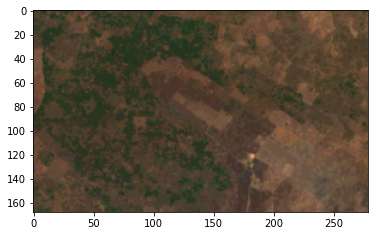

In [7]:
plt.imshow(base_im)
plt.show()

In [ ]:
geod = ccrs.Geodetic()

# Set Projection
proj = ccrs.Mercator(central_longitude=(lon_min+lon_max)/2, min_latitude=lon_max-0.2, max_latitude=lon_max+0.2, globe=None, latitude_true_scale=0.0)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Map bounds
# Entire eastern half of DRC 
#ease_extent = [2500000., 3500000., -1500000., 600000.]
# Zoomed in
# ease_extent = [2750000., 2900000., -1250000., -1150000.]
#ease_extent = [2800000., 2900000., -1250000., -1150000.]

# Set projection and boundaries
#ax = plt.axes(projection=proj)
#ax.set_extent(ease_extent, crs=proj)

# Map image onto the projection
#ax.imshow(base_im, extent=image_bounds(base_bounds), transform=proj, origin='upper')

ax.stock_img()

# Set gridlines, country borders, coastlines, title
#ax.gridlines(color='gray', linestyle='--')
#ax.coastlines()
#ax.add_feature(cf.BORDERS)
#plt.title('RGB.byte.tif')
# Clip image to fit projected region
#plt.tight_layout()
plt.show()